In [2]:
## 参考自：https://blog.51cto.com/u_8238263/6170341

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import matplotlib.pyplot as plt

from torch.autograd import Variable

from typing import *

# 1 输入部分

In [57]:
# 文本嵌入层
class Embeddings(nn.Module):
    
    def __init__(self, vocab_size: int, length: int):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab_size, length)
        self.length = length
    
    def forward(self, x):
        return self.lut(x) * math.sqrt(self.length)

    
# 位置编码器
class PositionalEncoding(nn.Module):
    
    def __init__(self, length: int, drop_out: float, max_len: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        self.dropout = nn.Dropout(p=drop_out)
        
        # 初始 0矩阵  max_len * length
        pe = torch.zeros(max_len, length)
        
        # max_len * 1
        position = torch.arange(0, max_len)[:, None]
        
        # 希望它能够将自然数的绝对位置编码缩放成足够小的数字
        div_term = torch.exp(torch.arange(0, length, 2) * (-math.log(10000.0) / length))
        # 偶数位置分布在正弦波上，奇数位置分布在余弦波上，最终填充在pe上
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # 需要与词嵌入向量（3维）相加，需要扩展维度  1 * max_len * length
        pe = pe[None, :]
        
        # 将pe注册为模型buffer（非参数或超参数，不需要随着优化步骤更新）
        self.register_buffer("pe", pe)
    
    def forward(self, x):
        """x为文本序列的词向量"""
        # pe切片，保证与词序列长度相同；且不需要梯度优化更新
        x = x + Variable(self.pe[:, :x.shape[1]], requires_grad=False)
        return self.dropout(x)

## 绘制词汇向量中位置特征的分布曲线

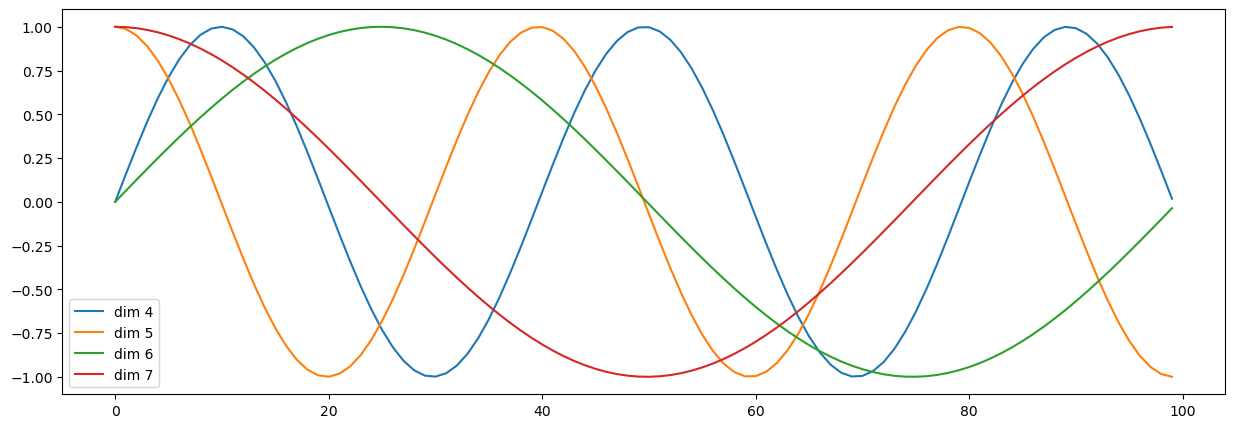

In [61]:
length = 20
word_length = 100
p = PositionalEncoding(length, drop_out=0)

word_vec = torch.zeros(1, word_length, length)
y = p(word_vec)   # 1 * word_length * length

plt.figure(figsize=(15, 5))
plt.plot(np.arange(word_length), y[0, :, 4:8].data.numpy())
plt.legend([f"dim {x}" for x in [4, 5, 6, 7]])

# 2 编码器部分

In [84]:
# 生成掩码向量，防止attention中张量计算时使用到未来信息
# 训练时会用到未来信息，但是理论上解码输出时只能通过上一次结果来产生，因此需要防止未来信息被提前利用。
def subsequent_mask(size: int) -> torch.Tensor:
    """生成向后遮掩的掩码向量，最后两维形成方阵"""
    attn_shape = (1, size, size)
    
    # 生成下三角阵，最终让右上角（不含对角线）为0  （左为前，右为后）
    # 最后为了节约内存，将数据类型变为uint8
    mask = 1 - np.triu(np.ones(attn_shape, dtype="uint8"), k=1)
    return torch.from_numpy(mask)

In [85]:
subsequent_mask(5)

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8)

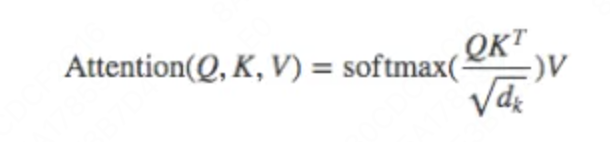

## 2.1 注意力机制

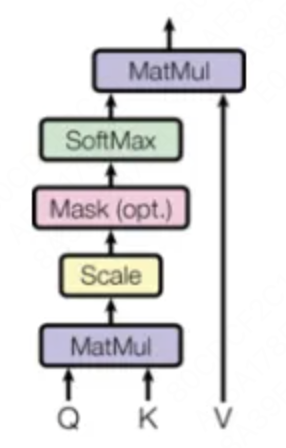

In [106]:
def attention(query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, 
              mask: torch.Tensor = None, dropout: nn.Dropout = None):
    """注意力机制的实现"""
    
    # 取最后一维，即词向量长度
    dk = query.size(-1)
    # 转置后两维，也称缩放点注意力计算
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(dk)
    if mask is not None:
        # 掩码为0对应的scores张量设为1e-9
        scores = scores.masked_fill(mask=0, value=1e-9)
    
    # 对scores最后一维进行softmax
    p_attn = F.softmax(scores, dim=-1)    # [B, S, S]
    
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    attn = torch.matmul(p_attn, value)    # [B, S, D]
    
    # 同时返回注意力表达和注意力张量
    return attn, p_attn

## 2.2 多头注意力

In [107]:
from copy import deepcopy

In [109]:
# 定义clone函数，因为多头注意力中会用到多个相同结构的线性层
def clones(module: nn.Module, n: int) -> nn.ModuleList:
    return nn.ModuleList([deepcopy(module) for _ in range(n)])

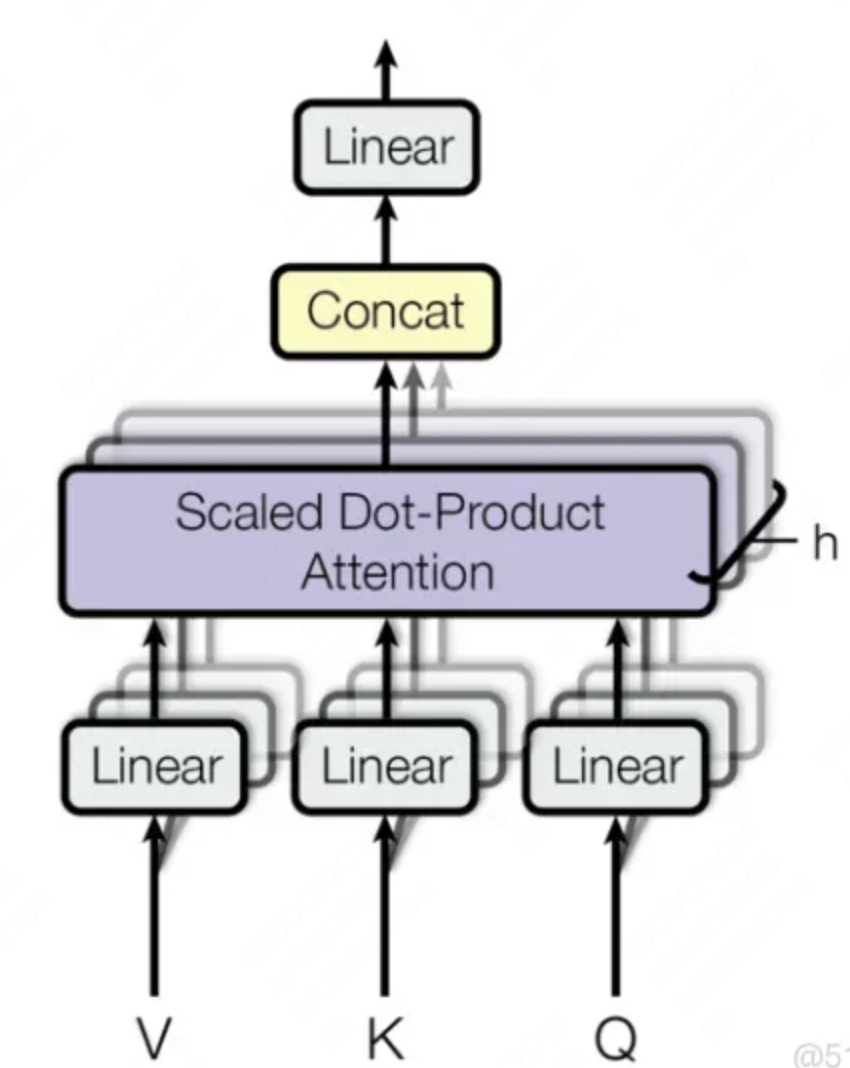

In [145]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self, h: int, embedding_length: int, dropout: float = 0.1):
        """
        @param h: 头数
        @param embedding_length: 词向量长度
        """
        super(MultiHeadedAttention, self).__init__()
        
        # 多头一定可以整除切分
        assert embedding_length % h == 0
        
        # 每个头可以获得的词向量长度
        self.dk = embedding_length // h
        self.h = h
        
        # 获取线性变化层对象，因为不改变形状，所以线性层参数形状为 (embedding_length, embedding_length)
        # 需要clone 4 个， Q、K、V各一个，然后最后拼接的矩阵还需要一个
        self.linears = clones(nn.Linear(embedding_length, embedding_length), 4)
        
        # 代表最终获得的注意力张量，还未计算初始化为 None
        self.attn = None
        
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        
        if mask is not None:
            mask = mask[None, :]
        
        # 获得样本数量
        batch_size = query.size(0)
        
        # 多头处理，最后一维切成多头，h * dk => [B, S, h, dk]
        # 对第2和第3维进行转置，是为了让代表句子长度的维度 S 和词向量维度 dk挨在一起
        # 从而与正规输入attention的张量（只用到最后两维）维度意义保持一致
        # 最终输出张量形状: [B, h, S, dk]
        query, key, value = [model(x).view(batch_size, -1, self.h, self.dk).transpose(1, 2) 
                             for model, x in zip(self.linears[:3], (query, key, value))]
        
        # 传入attention中
        # 注意力输出张量 x形状：[B, h, S, dk]
        # self.attn形状：[B, h, S, S]
        x, self.attn = attention(query, key, value, mask, self.dropout)
        
        # 从多头恢复，需要将维度重新转置回来，重塑形状
        # 需要用contiguous方法让张量内存排布适应当前形状
        # [B, h, S, dk] => [B, S, h, dk] => [B, S, h * dk] = [B, S, embedding_length]
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.dk)
        
        # 最后使用最后一个线性层做输出
        return self.linears[-1](x)

In [139]:
x = torch.Tensor([[1, 2, 3, 4, 5, 6]]).view(3, 2)
x

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])

In [144]:
x.view(-1)

tensor([1., 2., 3., 4., 5., 6.])

In [143]:
x.transpose(0, 1).contiguous().view(-1)

tensor([1., 3., 5., 2., 4., 6.])